# Load Libraries & Dataset
## Libraries

In [1]:
%cd ../..

C:\Users\fahmi\Documents\Github ML Project\time-series-projects


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from src.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

C:\Users\fahmi\AppData\Local\Temp\ipykernel_8148\3900436384.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## Dataset

In [3]:
energy = pd.read_csv('energy-consumption/datasets/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']
energy.index.freq = 'MS'
energy

,y
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326
...,...
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799


In [27]:
energy.describe()

,y
count,588.000000
mean,1551.824029
std,403.939753
min,901.700000
25%,1251.331250
50%,1466.218500
75%,1810.309750
max,2808.412000


In [4]:
energy.isnull().sum()

y    0
dtype: int64

# Helper Functions
## Unit Root Test Function

In [5]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

## Stationarity Technique Functions

In [21]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(12).mean().plot(ax=ax[v,r], legend=False)

# Exploratory Data Analysis (EDA) & Diagnosis
## Time Series Plot

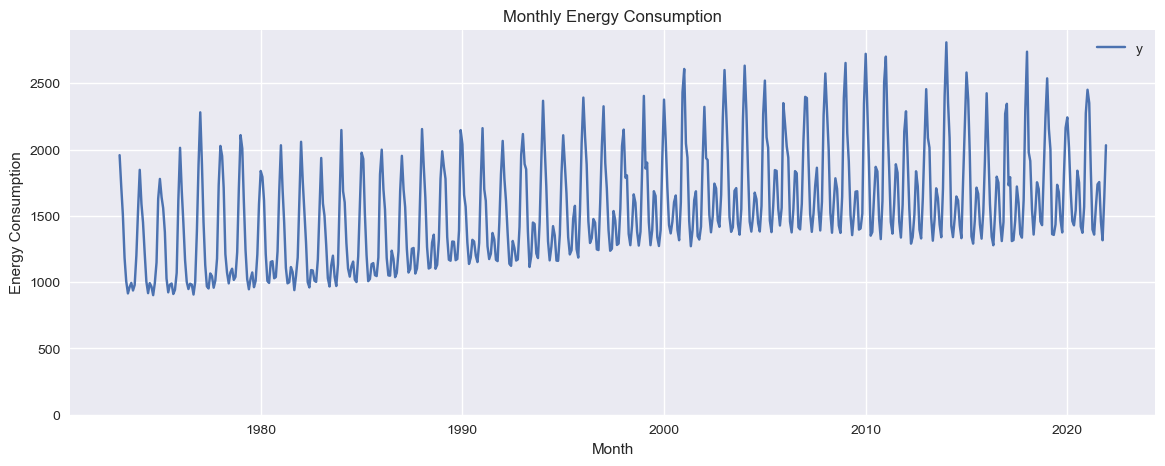

In [7]:
plt.rcParams["figure.figsize"] = [14, 5]  
sns.lineplot(energy)
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.ylim(0)
plt.title('Monthly Energy Consumption')
plt.show()

<Axes: title={'center': 'Monthly Energy Consumption'}, xlabel='Month'>

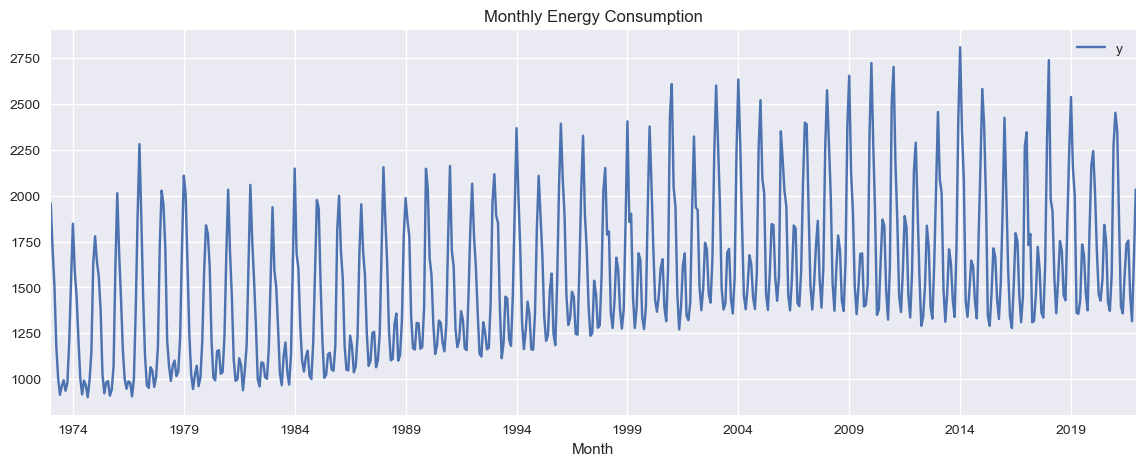

In [8]:
plt.rcParams["figure.figsize"] = [14, 5]  
energy.plot(title='Monthly Energy Consumption')

## HP Filter Time Series Plot

In [9]:
hpfilter(energy)

(Month
 1973-01-01    555.995491
 1973-02-01    334.227249
 1973-03-01    155.545510
 1973-04-01   -148.634115
 1973-05-01   -304.808231
                  ...    
 2021-08-01     64.275492
 2021-09-01   -227.149148
 2021-10-01   -361.791899
 2021-11-01    -27.266819
 2021-12-01    366.568156
 Freq: MS, Name: cycle, Length: 588, dtype: float64,
 Month
 1973-01-01    1401.645509
 1973-02-01    1377.915751
 1973-03-01    1354.533490
 1973-04-01    1332.055115
 1973-05-01    1311.134231
                  ...     
 2021-08-01    1690.936508
 2021-09-01    1684.050148
 2021-10-01    1677.590899
 2021-11-01    1671.572819
 2021-12-01    1665.783844
 Freq: MS, Name: trend, Length: 588, dtype: float64)

In [10]:
energy_cyclic, energy_trend = hpfilter(energy)

<Axes: title={'center': 'energy Trend Component'}, xlabel='Month'>

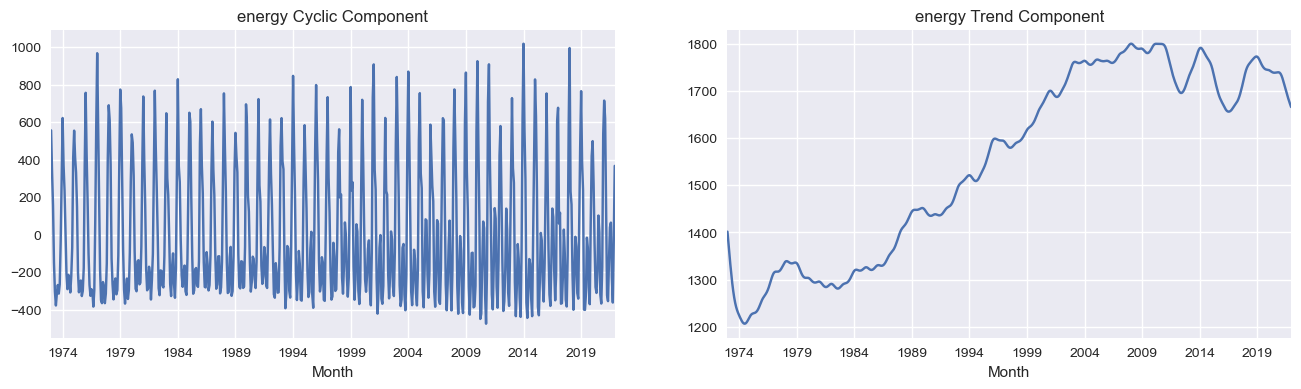

In [11]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
energy_cyclic.plot(ax=ax[0], title='energy Cyclic Component')
energy_trend.plot(ax=ax[1], title='energy Trend Component')
#fig.savefig('images/fig_.png', bbox_inches='tight')

## Decomposing Time Series

Figure(1400x800)


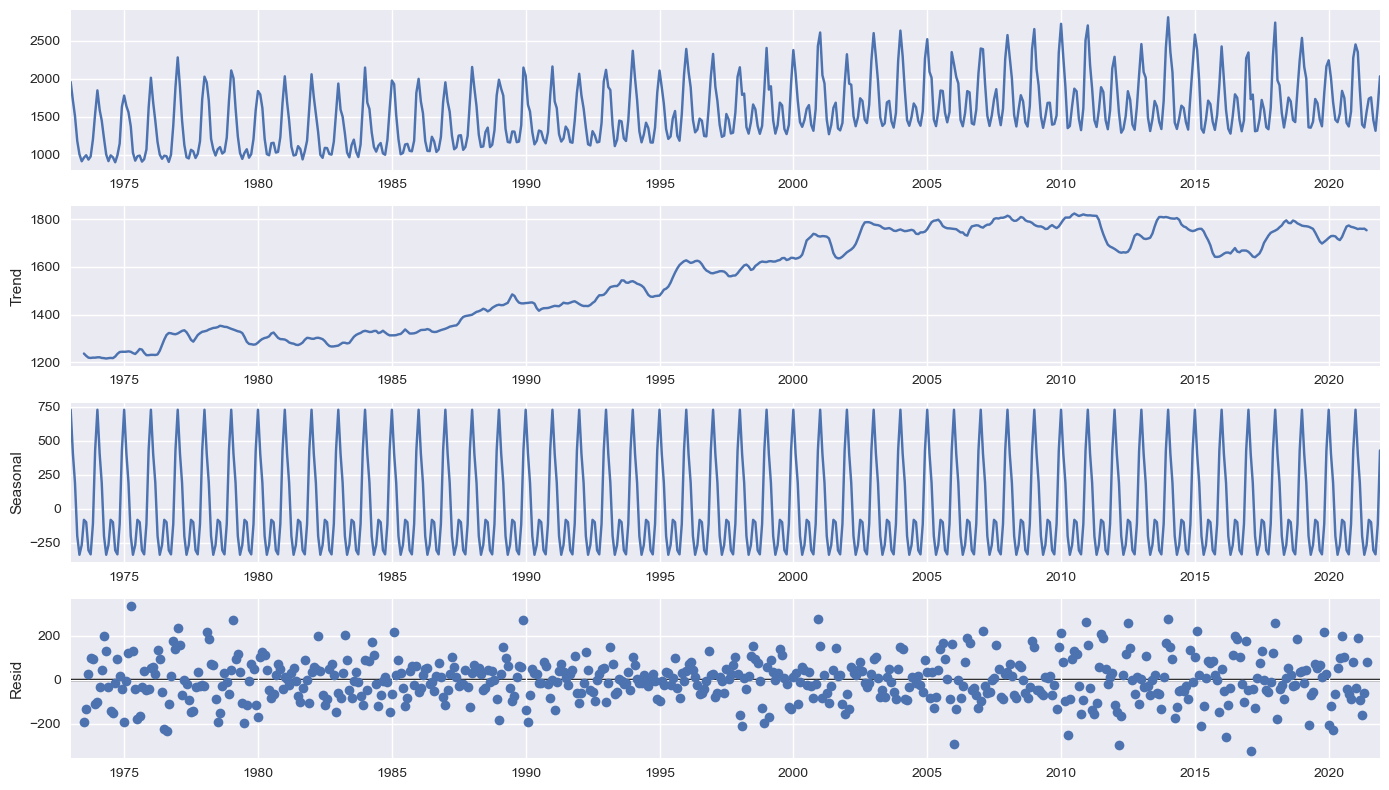

In [12]:
plt.rcParams["figure.figsize"] = [14, 8]
decomposition_result = seasonal_decompose(energy, model="addictive")
print(decomposition_result.plot())

## Stationarity check
### Detecting Unit Root: ADF & KPSS Test

In [13]:
adf_energy_output = adfuller(energy)
kpss_energy_output = kpss(energy)

pd.concat([
    unitroot_test_results(adf_energy_output, 'adf'),
    unitroot_test_results(kpss_energy_output, 'kpss')
], axis=1)

C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,adf,kpss
Test Statistic,-1.449733,4.940754
p-value,0.558215,0.01
Numbers of lags,12,6
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.441774,0.739
Critical Value (5%),-2.86658,0.463
Critical Value (10%),-2.569454,0.347
Critical Value (2.5%),NaN,0.574


### Detecting Trend

In [14]:
kendall_tau_res = check_trend(energy, confidence=0.05)
mann_kendall_res = check_trend(energy, confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(energy, confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: True | Direction: increasing | Deterministic: False


### Detrending & Deseasonalizing Techniques
#### AutoStationary

C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\transforms\target_transformations.py:545: UserWarning: Trends with degree>1 are very strong and use with care.
  warnings.warn("Trends with degree>1 are very strong and use with care.")
C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\decomposition\seasonal.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return lambda x: X.__class__(x, index=index, name=names)


Transformations applied: ['DetrendingTransformer', 'DeseasonalizingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


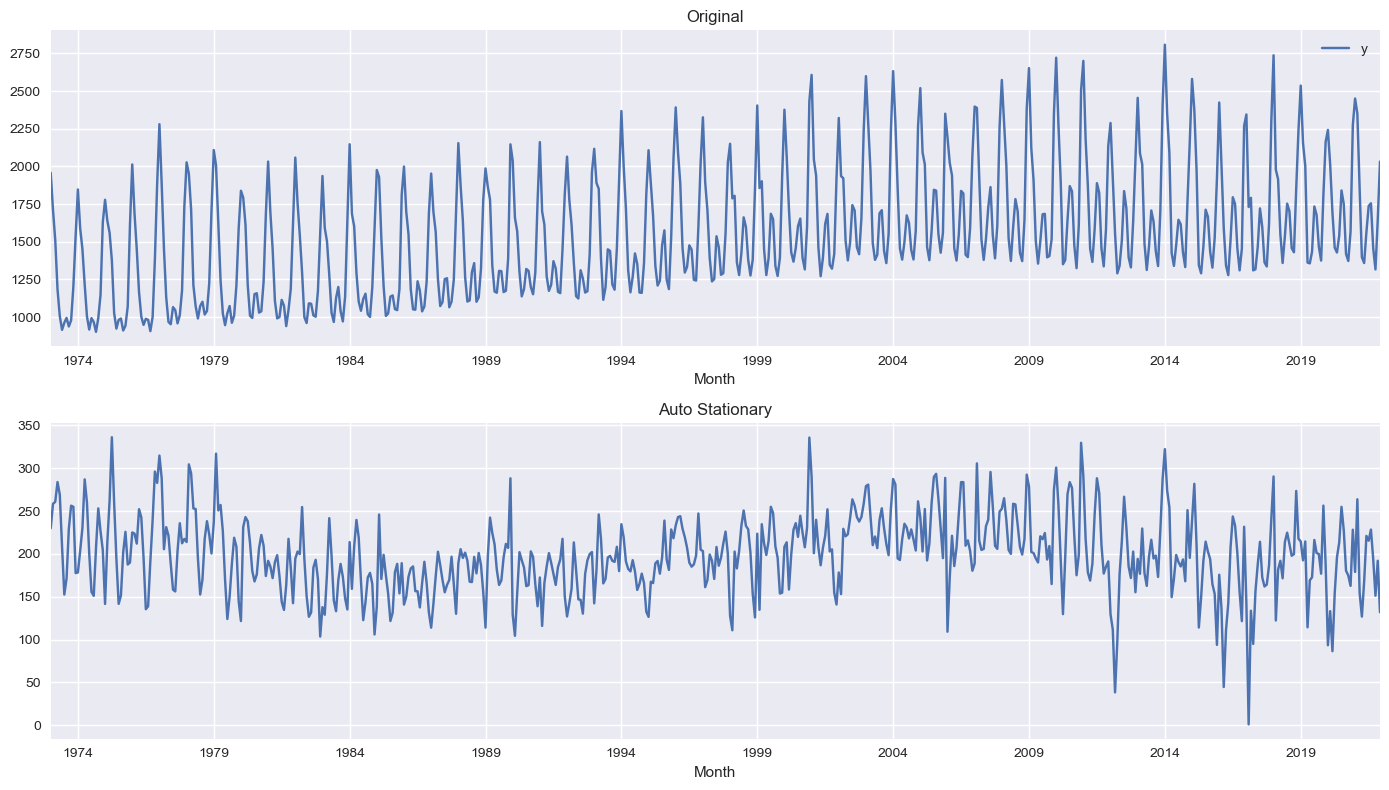

Unit Root: True with a p-value of 0.01370598509593634
Inverse == Original @ precision of 2 decimal points: True


In [18]:
auto_stationary = AutoStationaryTransformer(seasonal_period=12, 
                                            detrender_params={'degree':2}, 
                                            trend_check_params={"mann_kendall":True})
y_stat = auto_stationary.fit_transform(energy, )
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

energy.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.05)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), columns=["y"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==energy.round(3))}")

#### Other Techniques

Optimal Lambda: -0.23041077286445122


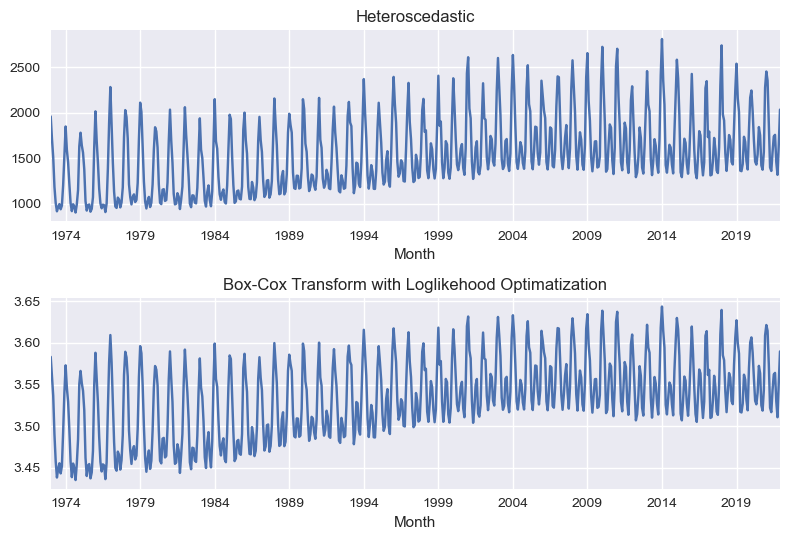

White Test for Heteroscedasticity: True with a p-value of 2.3434035359693946e-07


In [32]:
#shifting the series into positive domain
boxcox_transformer = BoxCoxTransformer(add_one=True, optimization="loglikelihood")
y_boxcox_loglikelihood = boxcox_transformer.fit_transform(energy["y"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")

fig, axs = plt.subplots(2)
energy["y"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_loglikelihood.plot(title="Box-Cox Transform with Loglikehood Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()

hetero_res = check_heteroscedastisticity(y_boxcox_loglikelihood, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

Optimal Lambda: 0.6496200962897908


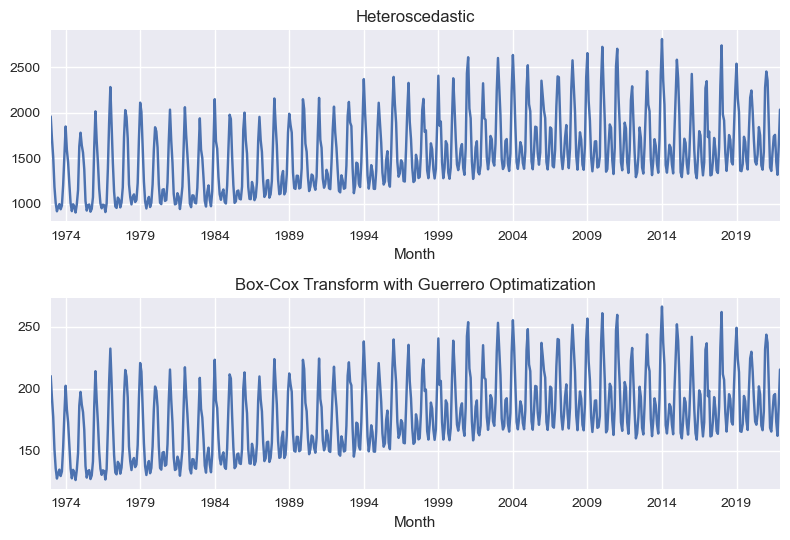

White Test for Heteroscedasticity: False with a p-value of 0.5037870613484776


In [33]:
#Arbritarily divided the data into sub-series of length 12
boxcox_transformer = BoxCoxTransformer(seasonal_period=12, add_one=True, optimization="guerrero")
y_boxcox_guerrero = boxcox_transformer.fit_transform(energy["y"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
energy["y"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_guerrero.plot(title="Box-Cox Transform with Guerrero Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox_guerrero, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

In [34]:
# using first order differencing (detrending)
first_ord_diff = energy.diff().dropna()

# using second order differencing
second_ord_diff = energy.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = energy.diff(12).dropna()

# using rolling mean 
rolling_mean = energy.rolling(window=12).mean()
subt_roll_mean = energy - rolling_mean

# log transform
log_transform = np.log(energy)

# Square root transform
square_root = np.sqrt(energy)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(energy)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(energy)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract,
           y_stat, y_boxcox_guerrero]

C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values ava

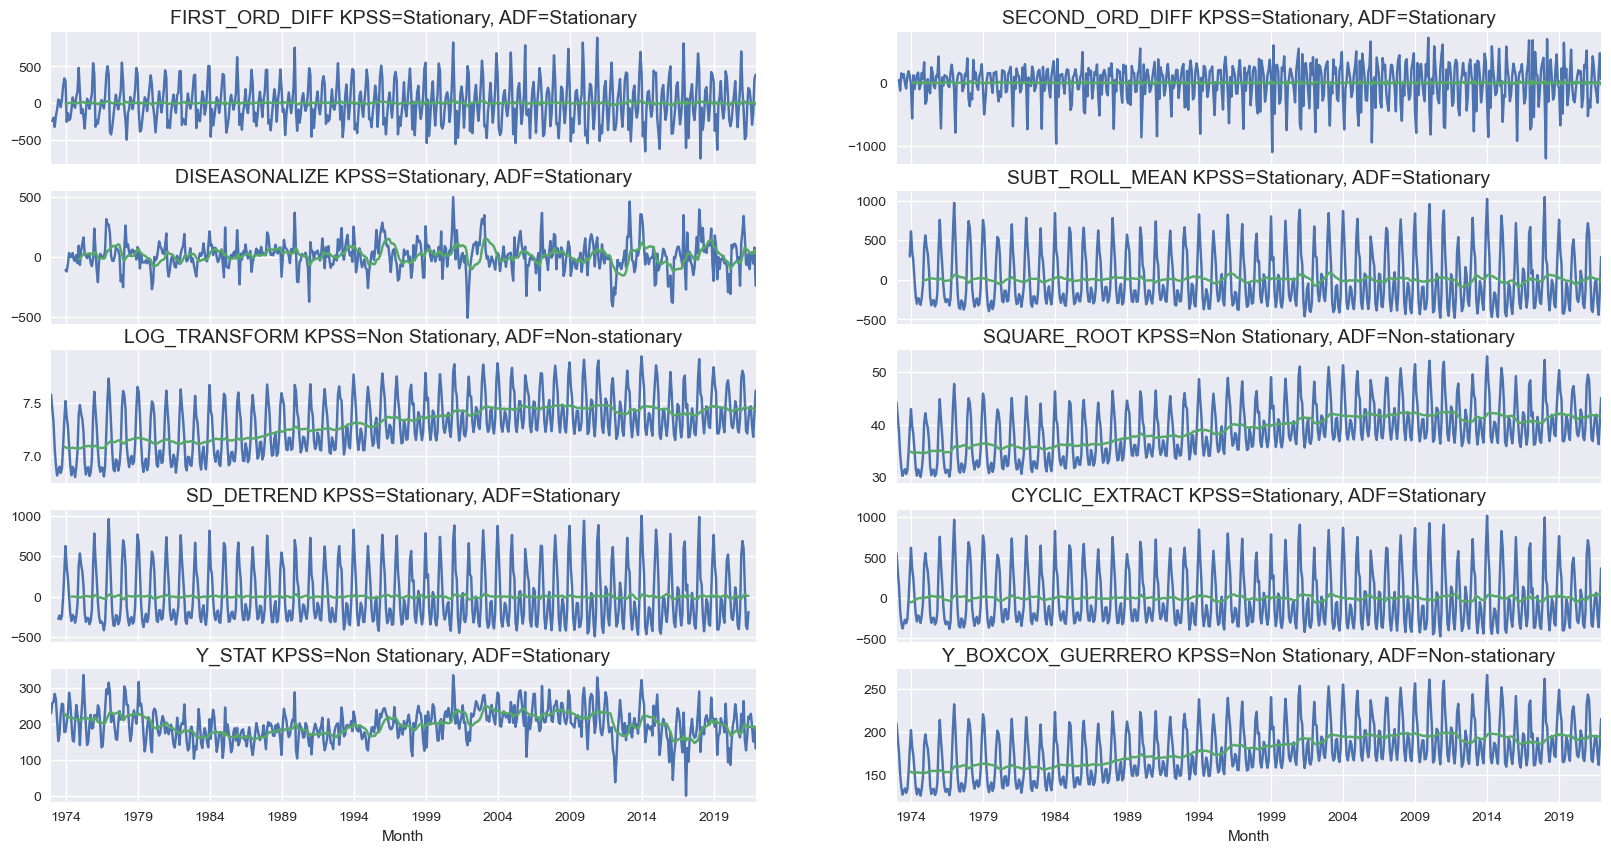

In [35]:
plot = plot_comparison(methods)

### Detecting Seasonality
#### Plotting ACF & PACF

Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


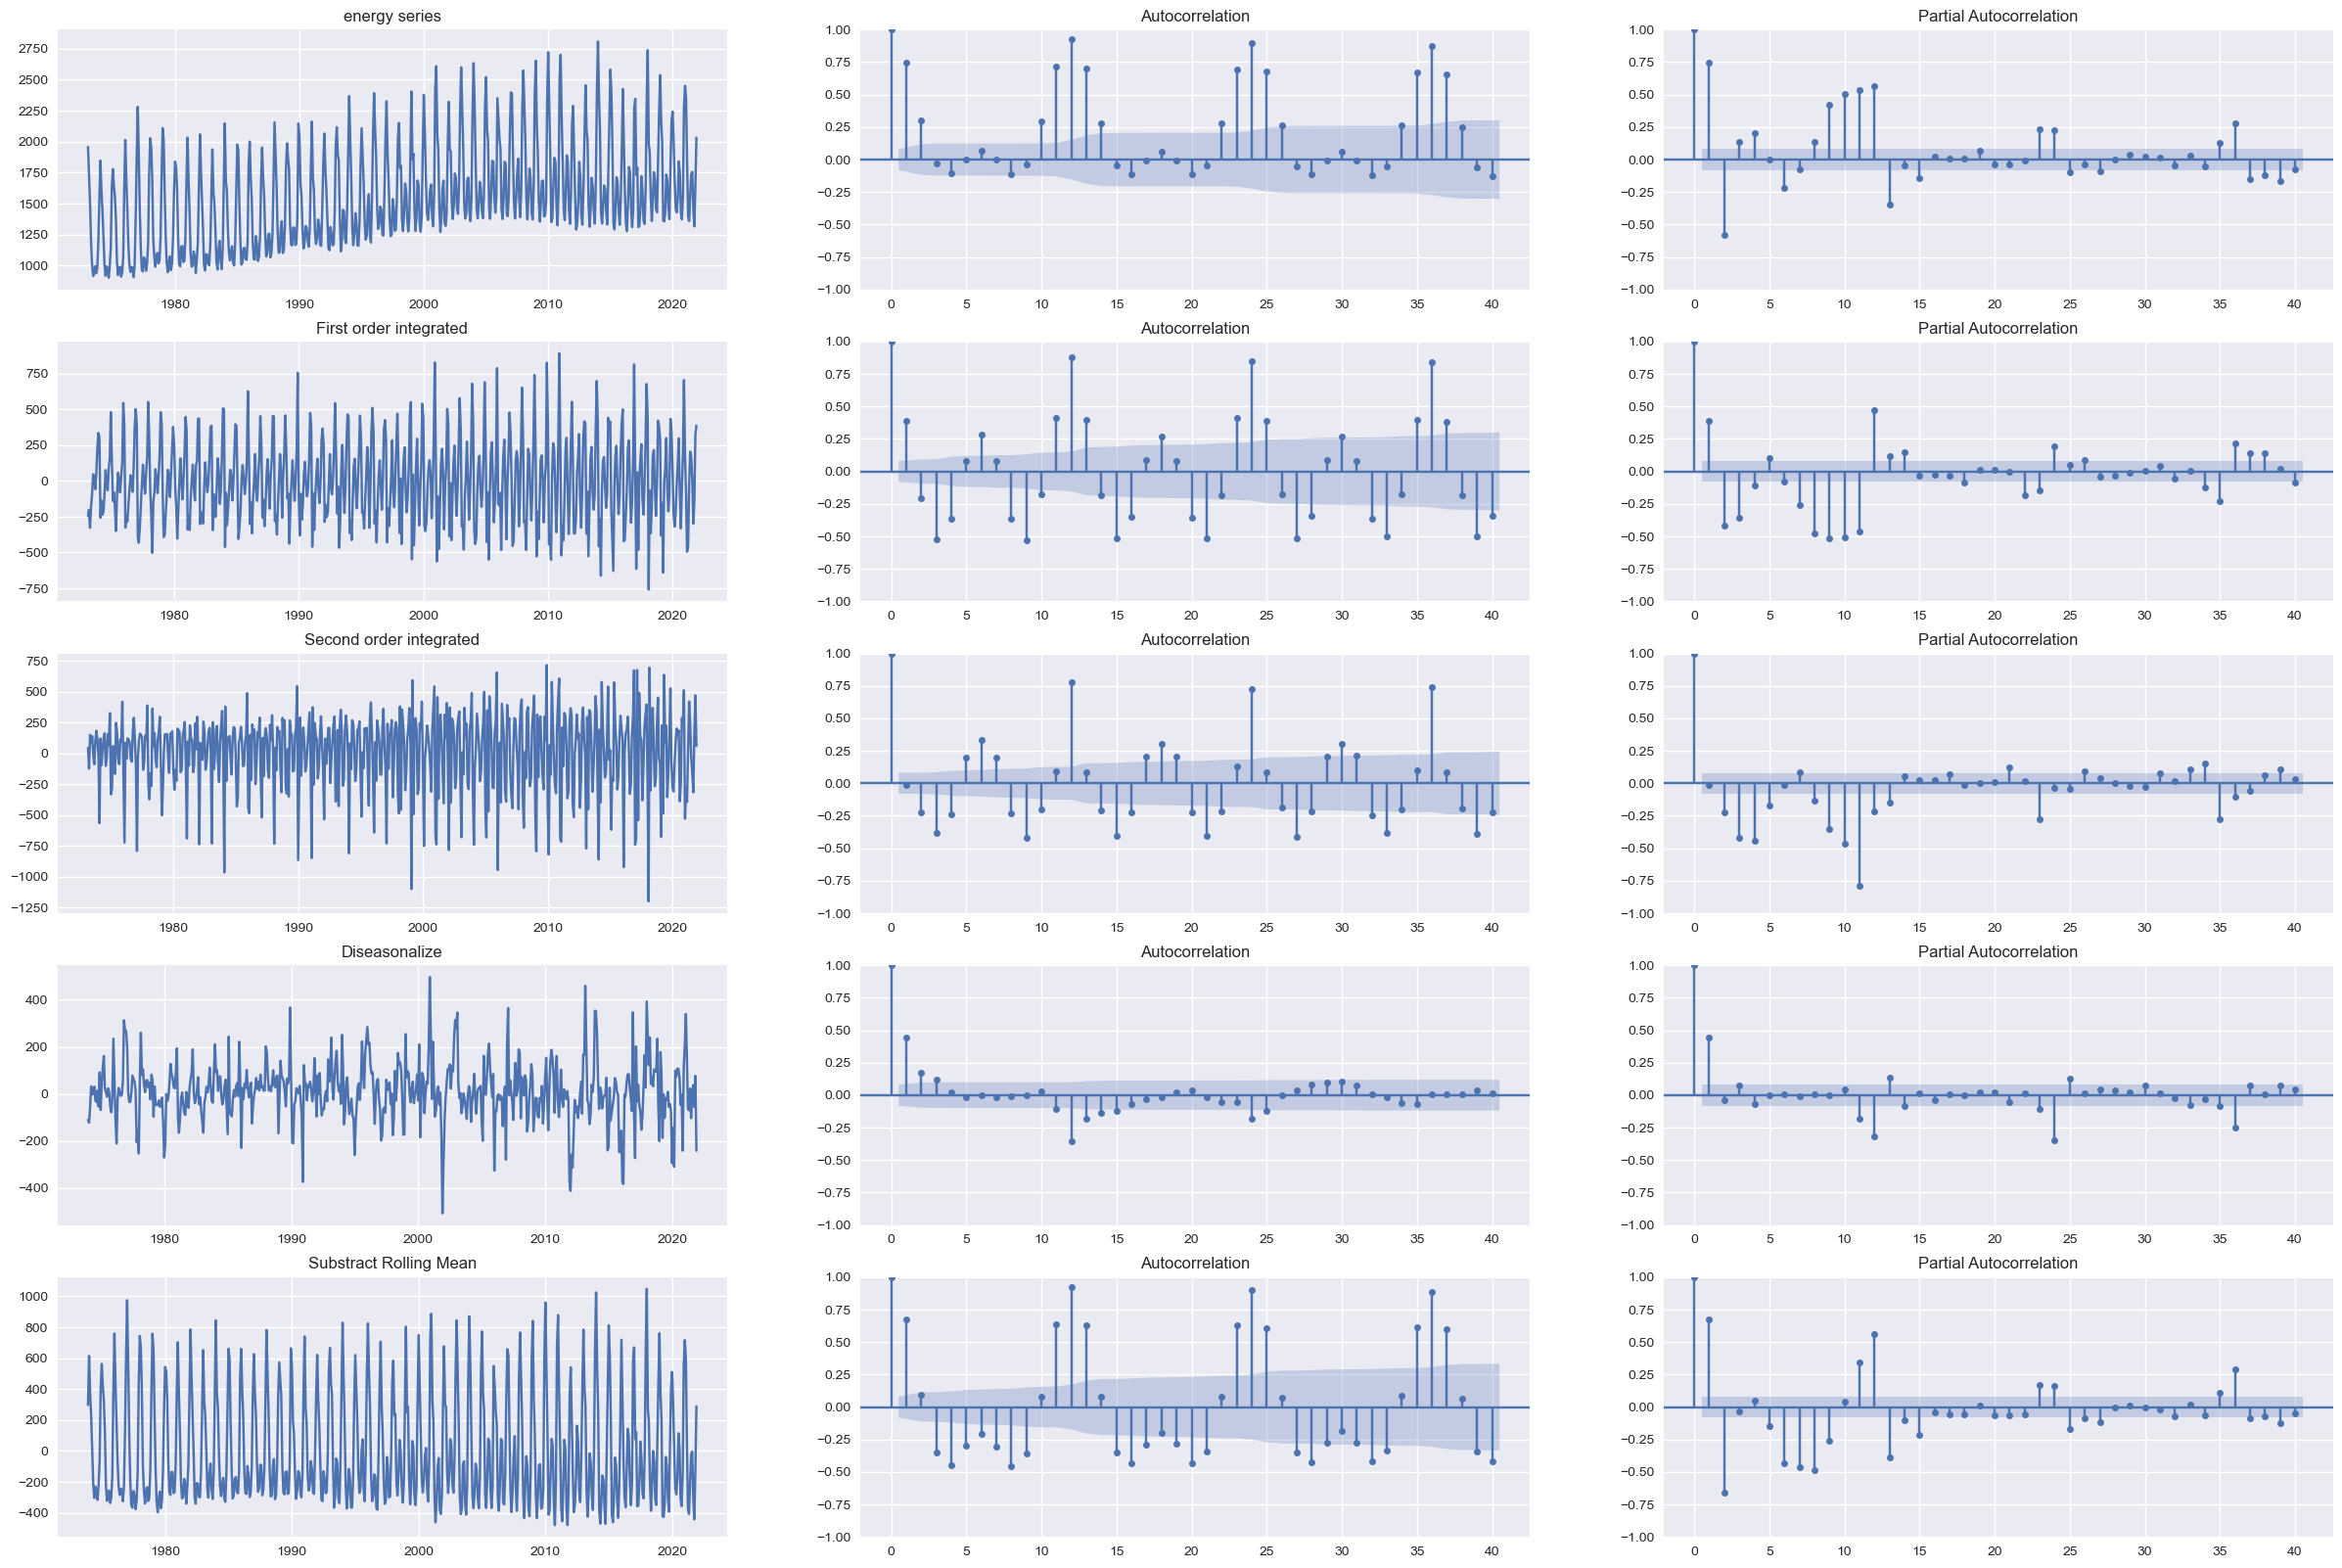

In [36]:
fig, axes = plt.subplots(5, 3, figsize=(30, 20))

# plot original series
axes[0,0].plot(energy)
axes[0,0].set_title("energy series")
print(plot_acf(energy, ax=axes[0,1], lags=40))
print(plot_pacf(energy, ax=axes[0,2], lags=40))

# plot first order integrated series
axes[1,0].plot(first_ord_diff)
axes[1,0].set_title("First order integrated")
print(plot_acf(first_ord_diff, ax=axes[1,1], lags=40))
print(plot_pacf(first_ord_diff, ax=axes[1,2], lags=40))

# plot first order integrated series
axes[2,0].plot(second_ord_diff)
axes[2,0].set_title("Second order integrated")
print(plot_acf(second_ord_diff, ax=axes[2,1], lags=40))
print(plot_pacf(second_ord_diff, ax=axes[2,2], lags=40))

# Deseasonalize series
axes[3,0].plot(diseasonalize)
axes[3,0].set_title("Diseasonalize")
print(plot_acf(diseasonalize, ax=axes[3,1], lags=40))
print(plot_pacf(diseasonalize, ax=axes[3,2], lags=40))

# Subtract Rolling Mean series
axes[4,0].plot(subt_roll_mean)
axes[4,0].set_title("Substract Rolling Mean")
print(plot_acf(subt_roll_mean, ax=axes[4,1], lags=40))
print(plot_pacf(subt_roll_mean, ax=axes[4,2], lags=40))

#### Detecting Statistically

In [50]:
def get_var_name(variable):
     for name, value in globals().items():
        if value is variable:
            return name
        
method_names = [get_var_name(method) for method in methods]

In [51]:
for method, method_name in zip(methods, method_names):
    seasonality_res = check_seasonality(method, max_lag=24, seasonal_period=12, confidence=0.05)
    print(f"Seasonality Test for 12th lag using {method_name}: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using first_ord_diff: True
Seasonality Test for 12th lag using second_ord_diff: True
Seasonality Test for 12th lag using diseasonalize: False
Seasonality Test for 12th lag using subt_roll_mean: True
Seasonality Test for 12th lag using log_transform: True
Seasonality Test for 12th lag using square_root: True
Seasonality Test for 12th lag using sd_detrend: True
Seasonality Test for 12th lag using cyclic_extract: True
Seasonality Test for 12th lag using y_stat: True
Seasonality Test for 12th lag using y_boxcox_guerrero: True


## Normality Test

In [52]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [53]:
normal_args = (np.mean(energy),np.std(energy))

print(is_normal(shapiro(energy)))
print(is_normal(normaltest(energy)))
print(is_normal(normal_ad(energy)))
print(is_normal(kstest_normal(energy)))

Not Normal
Not Normal
Not Normal
Not Normal


C:\Users\fahmi\anaconda3\envs\ts_model\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


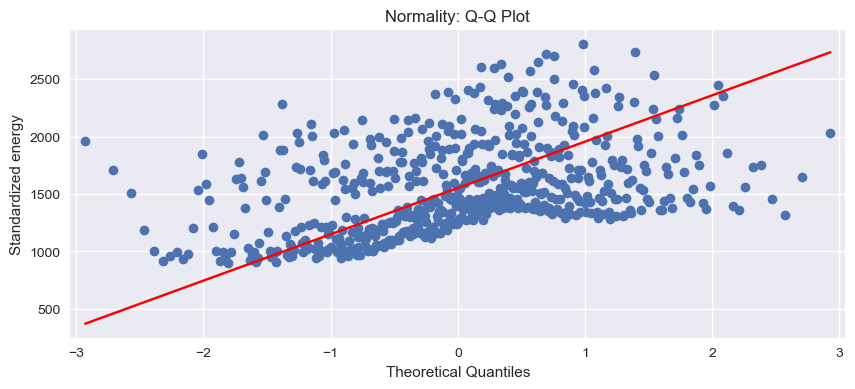

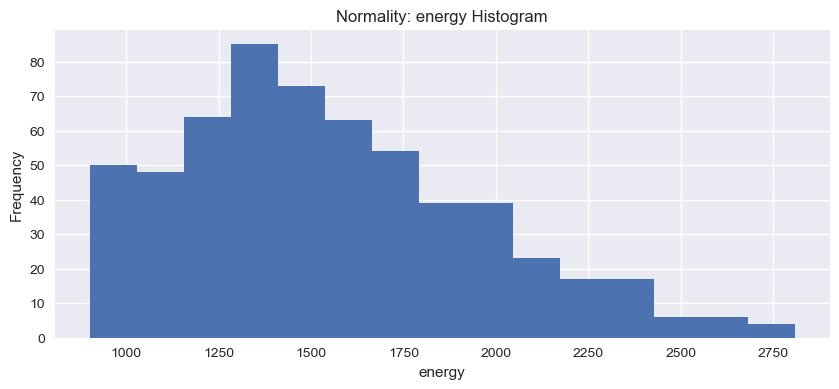

In [54]:
plt.rcParams["figure.figsize"] = [10, 4]

sm.qqplot(energy, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized energy')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(energy, bins='auto')
plt.xlabel('energy')
plt.ylabel('Frequency')
plt.title('Normality: energy Histogram')
plt.show()

## Heteroskedactisity Test 

In [55]:
for method, method_name in zip(methods, method_names):
    hetero_white_res = check_heteroscedastisticity(method, confidence=0.05)
    print(f"White Test for Heteroscedasticity on {method_name}: {hetero_white_res.heteroscedastic} with a p-value of {hetero_white_res.lm_p_value}")

White Test for Heteroscedasticity on first_ord_diff: True with a p-value of 0.00012520328505965955
White Test for Heteroscedasticity on second_ord_diff: True with a p-value of 6.719156092992545e-06
White Test for Heteroscedasticity on diseasonalize: True with a p-value of 0.0004235060248066252
White Test for Heteroscedasticity on subt_roll_mean: False with a p-value of 0.41967341032890737
White Test for Heteroscedasticity on log_transform: True with a p-value of 0.00020964017333355682
White Test for Heteroscedasticity on square_root: False with a p-value of 0.2959977498641993
White Test for Heteroscedasticity on sd_detrend: False with a p-value of 0.2670698588504783
White Test for Heteroscedasticity on cyclic_extract: False with a p-value of 0.42025888257348865
White Test for Heteroscedasticity on y_stat: True with a p-value of 0.003410197844937906
White Test for Heteroscedasticity on y_boxcox_guerrero: False with a p-value of 0.5037870613484776


In [ ]:
# hetero_bpagan_res = check_heteroscedastisticity(energy, confidence=0.05, test="breusch_pagan")
# print(f"Breusch Pagan Test for Heteroscedasticity: {hetero_bpagan_res.heteroscedastic} with a p-value of {hetero_bpagan_res.lm_p_value}")